![logo](../../../LogoLine_horizon_C3S.png)

<div class="alert alert-block alert-warning">
Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch
</div>

# Drought effect on LAI in Yunnan

Production date: 04-Jul-2025

Produced by: Amaya Camila Trigoso Barrientos (VUB)

## 🌍 Use case: Utilize satellite derived data to study the effect of drought periods on vegetation

## ❓ Quality assessment question(s)
**Does version 3 of the C3S LAI dataset (derived from SPOT satellite imagery) provide sufficient temporal and spatial completeness to capture the impact of the 2009–2010 drought on vegetation in Yunnan Province?**

The Leaf Area Index (LAI) and Fraction of Absorbed Photosynthetically Active Radiation (fAPAR) dataset, provided by the Climate Data Store (C3S), offers 10-daily gridded observations from 1981 to the present. It includes effective LAI values derived from multiple satellite sensors across different product versions. Effective LAI is defined as half the total surface area of photosynthetically active plant elements per unit of horizontal ground area. It relates to true LAI through a canopy-dependent structure factor. As a key biophysical parameter, LAI is widely used to assess vegetation status, monitor ecosystem dynamics, and inform environmental and agricultural decision-making.

This quality assessment focuses on version 3 of the LAI product. The data employed was derived from the System Pour l’Observation de la Terre (SPOT) satellite, Vegetation (VGT) sensor and has spatial resolution of 1 km and a 10-day temporal resolution (dekadal). The dataset is evaluated over Yunnan Province, China, in the context of the 2009–2010 drought. The objective is to determine whether the product’s spatial and temporal completeness is sufficient to detect drought-related changes in LAI, which serves as a proxy for vegetation health. This is particularly relevant in Yunnan, a biologically rich and forested region influenced by subtropical monsoon systems, where seasonal rainfall variability plays a critical role in vegetation dynamics.

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* Applying a relaxed quality filter (bitmask 0x9C1) significantly increases LAI data availability during the wet season in Yunnan, maintaining over 84% completeness. However, this comes at the cost of increased uncertainty, as it includes pixels affected by albedo-related issues.
* The conservative filter (bitmask 0xFC1), which excludes all flagged data, severely limits completeness during wet months—particularly from June to August—and especially in densely vegetated areas such as evergreen and mixed forests. However, this filter can be applied during the dry season with high completeness, while maintaining higher standards of data reliability.
* The analysis of spatial and monthly mean LAI in Yunnan successfully captured the effects of drought on vegetation health in 2010, with several months showing the lowest values when compared to other years between 2007 and 2013. In contrast, 2009 did not yet show a clear reduction in LAI, likely because the drought’s effects had not fully materialized or were masked by the averaging of localized impacts across the diverse region.
* The standardized LAI anomaly analysis effectively revealed below-normal vegetation conditions in southern—particularly southeastern—Yunnan between March and May 2010, and identified strong negative anomalies in northern and central Yunnan in November 2010.
```

## 📋 Methodology

The analysis and results are organised in the following steps, which are detailed in the sections below: 

**[](satellite_satellite-lai-fapar_extremes-detection_q02:section-1)**  
* Download LAI data from the SPOT satellite (VGT sensor) for the period 2007–2013.

**[](satellite_satellite-lai-fapar_extremes-detection_q02:section-2)**  
* Apply two distinct quality-masking approaches to filter the data.  
* Plot the percentage of valid LAI values over time for each approach.  
* Map LAI across Yunnan to compare the results from the two quality-masking methods.  
* Analyze the outcomes in relation to the dataset Documentation.

**[](satellite_satellite-lai-fapar_extremes-detection_q02:section-3)**  
* Calculate the spatial and monthly mean LAI, and plot the values for each year over the months of the year.
* Map LAI anomalies in 2010 relative to the reference years 2007–2008 and 2012–2013.

## 📈 Analysis and results

(satellite_satellite-lai-fapar_extremes-detection_q02:section-1)=
### 1. Request and download data

#### Import packages

In [60]:
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry
import regionmask
import xarray as xr
import os
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import requests as reqlib
import geopandas as gpd
import geopandas as gpd
import rioxarray
import matplotlib.colors as mcolors
from matplotlib import animation, pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm, Normalize
from c3s_eqc_automatic_quality_control import diagnostics, download
import matplotlib.cm as cm
import calendar
os.environ["CDSAPI_RC"] = os.path.expanduser("~/trigoso_camila/.cdsapirc")
plt.style.use("seaborn-v0_8-notebook")

#### Set parameters

In [3]:
year_start = 2007
year_stop = 2013

#### Define requests

In [4]:
collection_id = "satellite-lai-fapar"
base_request = {
    "variable": "lai",
    "sensor": "vgt",
    "horizontal_resolution": "1km",
    "product_version": "v3",
    "area": [53, 73, 18, 135],
}

requests = []
for time in pd.date_range(str(year_start), str(year_stop + 1), freq="ME"):
    requests.append(
        base_request
        | {
            "satellite": "spot",
            "year": str(time.year),
            "month": f"{time.month:02d}",
            "nominal_day": ["10", "20", str(time.day)],
        }
    )

In [5]:
def mask_dataset_with_shapefile(ds):
    # Load and reproject the shapefile to EPSG:4326
    gdf = gpd.read_file("/data/wp5/trigoso_camila/LeafIndex/yunnan_china")
    gdf = gdf.to_crs("EPSG:4326")

    # Ensure dataset has a CRS
    if not ds.rio.crs:
        ds = ds.rio.write_crs("EPSG:4326")

    # Create mask from shapefile
    mask = ds.rio.clip(gdf.geometry, gdf.crs, drop=False, invert=False)

    # Create a boolean mask (True where valid, False outside the shape)
    spatial_mask = mask.notnull()

    # Apply the mask to the original dataset (similar to ds.where(...))
    ds_masked = ds.where(spatial_mask)
    return ds_masked

#### Download and transform

In [6]:
ds = download.download_and_transform(
    collection_id,
    requests,
    transform_func=mask_dataset_with_shapefile
)

100%|██████████| 84/84 [00:19<00:00,  4.40it/s]


(satellite_satellite-lai-fapar_extremes-detection_q02:section-2)=
### 2. Completeness analysis

#### Filter data

In this step, the dataset was spatially subsetted using a shapefile of Yunnan, an inland province in southwestern China. The shapefile was sourced from the [Natural Earth, Admin 1 – States, Provinces Shapefile](https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces.zip).

To filter out unreliable data, two distinct quality-masking strategies were applied:

* **Conservative:** Retains only the highest-quality retrievals by applying bitmask 0xFC1. This mask excludes data flagged with any of the following bits: 0, 6, 7, 8, 9, 10, and 11, corresponding to missing input data, untrusted retrievals, unusable observations, inconsistent inputs, high albedo uncertainty (both snow and non-snow), and unreliable uncertainty estimates.
* **Relaxed filter:** Permits retrievals with high albedo uncertainty (considered still usable), using bitmask 0x9C1. This mask excludes a smaller subset of flags: bits 0, 6, 7, 8, and 11, while allowing data flagged only for high albedo uncertainty in non-snow and snow conditions (bits 9 and 10).

These bitmasks are defined in Table 2, with flag definitions detailed in Table 7 of the [Product User Guide and Specification PUGS](http://dast.data.compute.cci2.ecmwf.int/documents/satellite-lai-fapar/D3.3.9-v3.0_PUGS_CDR_LAI_FAPAR_MULTI_SENSOR_v3.0_PRODUCTS_v1.0.1.pdf). 

The goal of this comparison was to assess how different treatments of uncertainty flags affect data completeness over Yunnan, particularly during periods of increased retrieval uncertainty such as the rainy season.

In [7]:
def clip_to_shapefile(ds, shapefile_path):
    """
    Clips an xarray dataset to a region defined by a shapefile.
    """
    # Step 1: Load shapefile and ensure it's in EPSG:4326
    gdf = gpd.read_file(shapefile_path)
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")

    # Step 2: Assign CRS to the dataset if not already
    ds = ds.rio.write_crs("EPSG:4326", inplace=True)

    # Step 3: Clip dataset using shapefile
    ds_clipped = ds.rio.clip(gdf.geometry, gdf.crs, drop=True)
    return ds_clipped

def filter_conservative(ds):
    """
    Filters the dataset using a strict quality mask:
    Only keeps retrievals with all critical flags unset (bitmask 0xFC1).
    Requirement Table 2, PUGS: Best possible data with uncertainties.
    """
    quality_mask = (ds["retrieval_flag"].astype("int") & 0xFC1) == 0
    lai_mask = ds["LAI"] >= 0
    return ds.where(quality_mask & lai_mask)

def filter_relaxed(ds):
    """
    Filters the dataset using a relaxed quality mask:
    Allows uncertainty (bitmask 0x9C1).
    Requirement Table 2, PUGS: Ignore all issues caused by high albedo uncertainties
    """
    quality_mask = (ds["retrieval_flag"].astype("int") & 0x9C1) == 0
    lai_mask = ds["LAI"] >= 0
    return ds.where(quality_mask & lai_mask)

In [8]:
# Step 1: Clip to ROI
ds_clipped = clip_to_shapefile(ds, "/data/wp5/trigoso_camila/LeafIndex/yunnan_china")

# Step 2a: Apply strict quality filtering
ds_conservative = filter_conservative(ds_clipped)

# Step 2b: Apply relaxed quality filtering
ds_relaxed = filter_relaxed(ds_clipped)

In [ ]:
#With conservative filter 0xFC1
ds_conservative["LAI"] = ds_conservative["LAI"].where(np.isfinite(ds_conservative["LAI"]))

gdf = gpd.read_file("/data/wp5/trigoso_camila/LeafIndex/yunnan_china")
gdf = gdf.to_crs("EPSG:4326")
# Step 1: Use the original ds_yunnan to assign CRS if needed
ds_conservative = ds_conservative.rio.write_crs("EPSG:4326")

# Step 2: Create a dummy DataArray to match spatial dims (lat/lon), e.g., filled with ones
dummy = xr.full_like(ds_conservative['LAI'].isel(time=0), fill_value=1)
dummy = dummy.rio.write_crs("EPSG:4326")

# Step 3: Clip the dummy array to get a clean mask of the region
clipped = dummy.rio.clip(gdf.geometry, gdf.crs, drop=False)

# Step 4: This gives us a proper mask of where the region is defined
region_mask = clipped.notnull()

# Step 5: Broadcast to full shape (time, lat, lon)
region_mask_3d = region_mask.broadcast_like(ds_conservative['LAI'])

valid_mask = ds_conservative['LAI'].notnull() & region_mask_3d
valid_counts = valid_mask.sum(dim=["latitude", "longitude"]).compute()

total_yunnan_pixels = region_mask.sum().compute()

valid_percentage = (valid_counts / total_yunnan_pixels) * 100

In [ ]:
#With conservative filter 0xFC1
# Step 5: Extract months from time coordinate
months = valid_percentage.time.dt.month

# Step 6: Create rainbow colormap for months (1=red, 12=blue)
# Using a custom colormap that goes from red to blue through rainbow
colors = plt.cm.rainbow(np.linspace(0, 1, 12))  # 12 colors for 12 months
month_colors = [colors[month-1] for month in months.values]

# Step 7: Create the plot
fig, ax = plt.subplots(figsize=(12, 6), dpi=250)
scatter = ax.scatter(valid_percentage.time, valid_percentage, 
                    c=month_colors, s=20, alpha=0.7, edgecolors='black', linewidth=0.2)

ax.set_title("Percentage of Valid LAI Values Over Time (conservative filter)")
ax.set_ylabel("Valid LAI (%)")
ax.set_xlabel("Time")
ax.grid(True, alpha=0.3)

# Add a colorbar to show month mapping
sm = plt.cm.ScalarMappable(cmap=plt.cm.rainbow, 
                          norm=plt.Normalize(vmin=1, vmax=12))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.set_label('Month')
cbar.set_ticks(range(1, 13))
cbar.set_ticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tight_layout()
plt.savefig("/data/wp5/trigoso_camila/LeafIndex/fig/yunnan_percentage_valid_conservative0xFC1.png", dpi=250, bbox_inches="tight")
plt.show()

```{figure} 4ab8c1cf-a5fe-4180-8597-36d9d5372994.png
---
name: fig-completeness_conservative
figwidth: 100%
---
Percentage of valid LAI values inside Yunnan area appliying the conservative mask (0xFC1). This percentage is plotted over time the points color coded for the month of each respective timestamp.
```

In [ ]:
#With 0x9C1 flag
ds_relaxed["LAI"] = ds_relaxed["LAI"].where(np.isfinite(ds_relaxed["LAI"]))

gdf = gpd.read_file("/data/wp5/trigoso_camila/LeafIndex/yunnan_china")
gdf = gdf.to_crs("EPSG:4326")
# Step 1: Use the original ds_yunnan to assign CRS if needed
ds_relaxed = ds_relaxed.rio.write_crs("EPSG:4326")

# Step 2: Create a dummy DataArray to match spatial dims (lat/lon), e.g., filled with ones
dummy = xr.full_like(ds_relaxed['LAI'].isel(time=0), fill_value=1)
dummy = dummy.rio.write_crs("EPSG:4326")

# Step 3: Clip the dummy array to get a clean mask of the region
clipped = dummy.rio.clip(gdf.geometry, gdf.crs, drop=False)

# Step 4: This gives us a proper mask of where the region is defined
region_mask = clipped.notnull()

# Step 5: Broadcast to full shape (time, lat, lon)
region_mask_3d = region_mask.broadcast_like(ds_relaxed['LAI'])

valid_mask = ds_relaxed['LAI'].notnull() & region_mask_3d
valid_counts = valid_mask.sum(dim=["latitude", "longitude"]).compute()

total_yunnan_pixels = region_mask.sum().compute()

valid_percentage = (valid_counts / total_yunnan_pixels) * 100

In [ ]:
#With 0x9C1 flag

# Step 5: Extract months from time coordinate
months = valid_percentage.time.dt.month

# Step 6: Create rainbow colormap for months (1=red, 12=blue)
# Using a custom colormap that goes from red to blue through rainbow
colors = plt.cm.rainbow(np.linspace(0, 1, 12))  # 12 colors for 12 months
month_colors = [colors[month-1] for month in months.values]

# Step 7: Create the plot
fig, ax = plt.subplots(figsize=(12, 6), dpi=250)
scatter = ax.scatter(valid_percentage.time, valid_percentage, 
                    c=month_colors, s=20, alpha=0.7, edgecolors='black', linewidth=0.2)

ax.set_title("Percentage of Valid LAI Values Over Time (relaxed filter)")
ax.set_ylabel("Valid LAI (%)")
ax.set_xlabel("Time")
ax.grid(True, alpha=0.3)

# Add a colorbar to show month mapping
sm = plt.cm.ScalarMappable(cmap=plt.cm.rainbow, 
                          norm=plt.Normalize(vmin=1, vmax=12))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.set_label('Month')
cbar.set_ticks(range(1, 13))
cbar.set_ticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tight_layout()
plt.savefig("/data/wp5/trigoso_camila/LeafIndex/fig/yunnan_percentage_valid_relaxed_0x9C1.png", dpi=250, bbox_inches="tight")
plt.show()

```{figure} 06c74548-52e2-453d-b462-948ccbde39b9.png
---
name: fig-completeness_relaxed
figwidth: 100%
---
Percentage of valid LAI values inside Yunnan area appliying the relaxed mask (0x9C1). This percentage is plotted over time the points color coded for the month of each respective timestamp.
```

In [45]:
# 1. Updated color list:
# 0–0.2: white
# 0.2–0.4: light yellow → 0.6: yellow → 0.8: deep yellow-green
# 0.8–2.0: greens (dense vegetation)

color_list = [
    "#ffffff",  # 0.0–0.2: white (bare)
    "#ffffcc",  # 0.2–0.4: light yellow
    "#ffeda0",  # 0.4–0.6: yellow
    "#addd8e",  # 0.6–0.8: yellow-green
    "#74c476",  # 0.8–1.0: healthy green
    "#41ab5d",  # 1.0–1.2: darker green
    "#238b45",  # 1.2–1.4: deep green
    "#006d2c",  # 1.4–1.6: forest green
    "#00441b",  # 1.6–2.0: very dark green
]

bounds = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 2.0]
norm = BoundaryNorm(boundaries=bounds, ncolors=len(color_list), clip=True)
custom_cmap = ListedColormap(color_list)
custom_cmap.set_bad("dimgray")
custom_cmap.set_under("lightgray")

In [46]:
def plot_lai_comparison(ds_conservative, ds_relaxed, date, custom_cmap, norm, bounds, output_path):
    # 1. Extract LAI data for the given date
    lai_conservative = ds_conservative.sel(time=date)["LAI"]
    lai_relaxed = ds_relaxed.sel(time=date)["LAI"]

    # 2. Create subplot with PlateCarree projection
    fig, axes = plt.subplots(1, 2, figsize=(14, 6),
                             subplot_kw={'projection': ccrs.PlateCarree()},
                             dpi=200)

    # 3. Plot Conservative
    im0 = lai_conservative.plot.imshow(
        ax=axes[0],
        cmap=custom_cmap,
        norm=norm,
        add_colorbar=False
    )
    axes[0].set_title("Conservative Filter")
    axes[0].coastlines()
    gl0 = axes[0].gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl0.top_labels = gl0.right_labels = False

    # 4. Plot Relaxed
    im1 = lai_relaxed.plot.imshow(
        ax=axes[1],
        cmap=custom_cmap,
        norm=norm,
        add_colorbar=False
    )
    axes[1].set_title("Relaxed Filter")
    axes[1].coastlines()
    gl1 = axes[1].gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl1.top_labels = gl1.right_labels = False
    gl1.left_labels = False  # Avoid duplicate y-axis labels

    # 5. Shared colorbar
    cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
    cb = fig.colorbar(im1, cax=cbar_ax, ticks=bounds, extend='max')
    cb.set_label("Effective LAI [m²/m²]")

    # 6. Final formatting
    plt.suptitle(f"LAI Comparison on {date} (Yunnan)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])

    # 7. Save & show
    save_path = f"{output_path}/yunnan_LAI_comparison_{date}.png"
    plt.savefig(save_path, dpi=250, bbox_inches="tight")
    plt.show()

/data/wp5/.tmp/ipykernel_1751394/3934487235.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


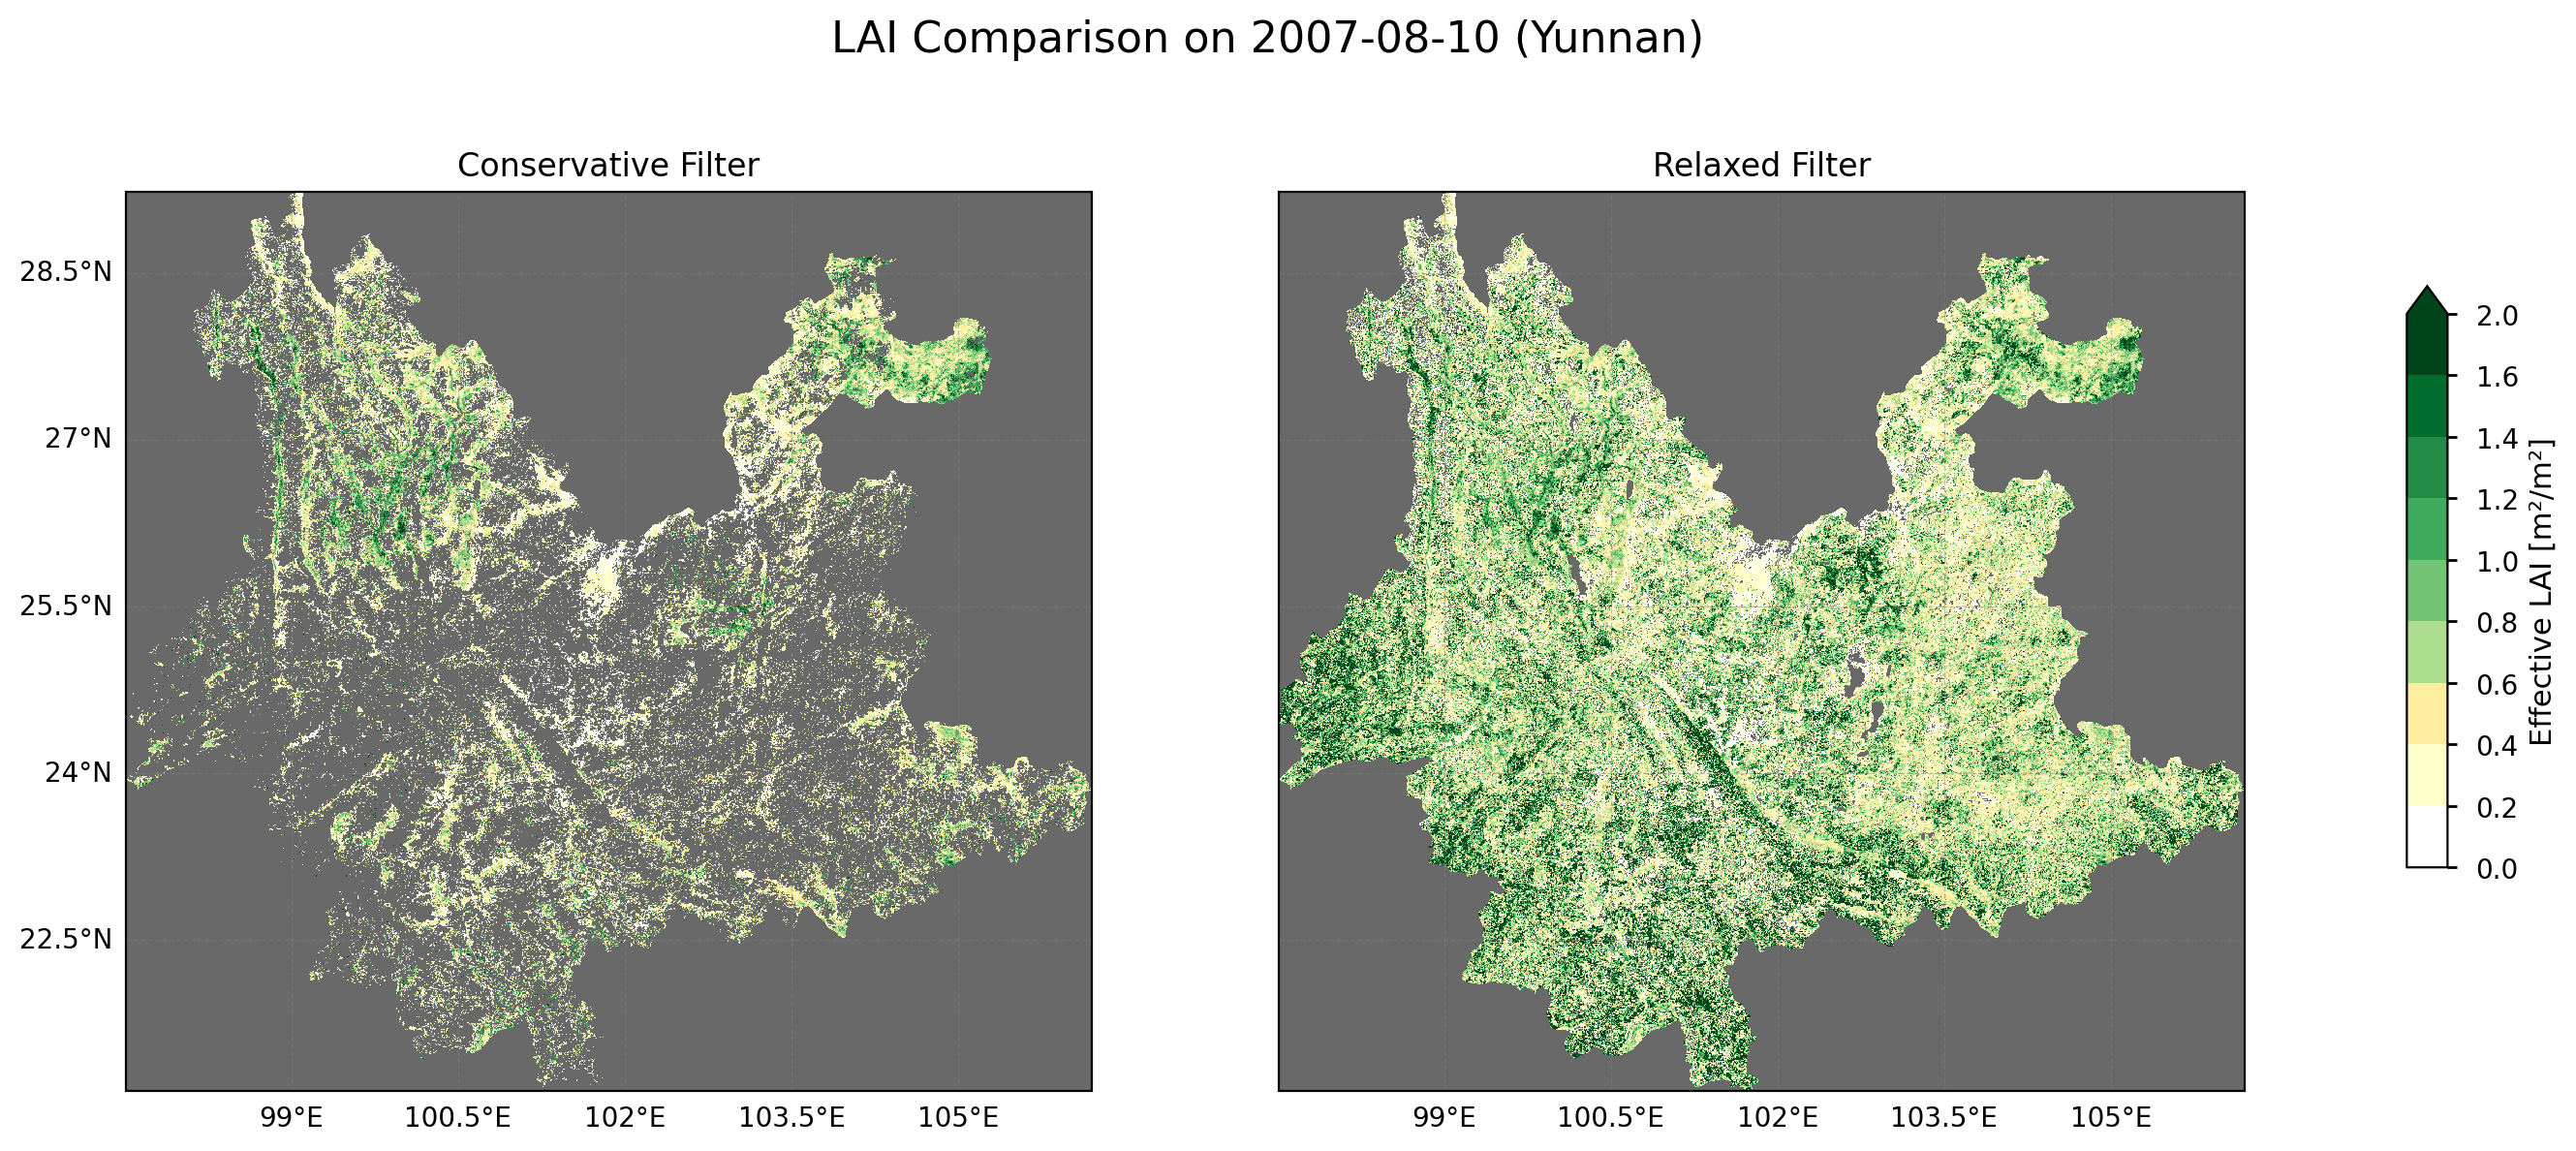

In [48]:
plot_lai_comparison(
    ds_conservative=ds_conservative,
    ds_relaxed=ds_relaxed,
    date="2007-08-10",
    custom_cmap=custom_cmap,
    norm=norm,
    bounds=bounds,
    output_path="/data/wp5/trigoso_camila/LeafIndex/fig"
)


```{figure} 8fba81fa-a581-42f8-8d1f-b7e5e210458b.png
---
name: fig-comparison
figwidth: 100%
---
Example illustrating differences in data completeness under different uncertainty flag approaches. The selected date, August 10, 2007, falls within the wet season of a non-drought year.
```


```{figure} 58c59c75-ae9e-4470-a5cf-7aa13dda224f.png
---
name: fig-land_cover
figwidth: 80%
---
Land cover map of Yunnan based on MODIS Land Surface Type data product -MCD12Q1. Figure reproduced from Kim et al. (2017) [[2]](https://doi.org/10.1007/s11629-016-3971-x).

```

Using the conservative filter, the percentage of valid LAI data in Yunnan drops significantly between June and August, reaching levels below 20%. Adjacent months such as May and September also show reduced data completeness (see {numref}`fig-completeness_conservative`). This pattern corresponds to Yunnan’s marked wet and dry seasons [[1]](https://www.sciencedirect.com/science/article/pii/S1872203213000577?casa_token=42igXD4HJb0AAAAA:dUjDmwTtatAJjay4r4YeTUM72Dobqck7rnenPh_nHku9aJD8nt68FQMmJFKZBka0YgV56oLZ_ky4), where the rainy season leads to a higher frequency of missing observations and albedo-related uncertainties, mainly due to cloud cover and wet canopy conditions.

In contrast, when applying the relaxed filter, the percentage of valid LAI data remains consistently above 84% throughout the period studied (2007–2013) (see {numref}`fig-completeness_relaxed`). This improvement is due to the relaxed mask allowing pixels flagged only for high albedo uncertainty in both non-snow and snow conditions (bits 9 and 10). In this context, bit 9 often relates to reflectance disturbances caused by clouds or wet vegetation, which are prevalent in Yunnan during the rainy season. As shown in Figure 15 of the [PQAR](https://dast.copernicus-climate.eu/documents/satellite-lai-fapar/D2.3.9-v3.0_PQAR_CDR_LAI_FAPAR_MULTI_SENSOR_v3.0_PRODUCTS_v1.1.pdf), the study area is frequently affected by the activation of bit 9, especially during wet months. It can also be observed that the dry months at the end of the year (November–December) exhibit higher completeness in {numref}`fig-completeness_relaxed`, but the difference between wet and dry seasons is significantly less pronounced than under the conservative filter.

By examining the maps comparing the conservative and relaxed approaches (like the example in {numref}`fig-comparison`) across different dates, it was observed that areas with missing values under the conservative approach often correspond to regions showing high LAI in the relaxed approach. When compared with the land cover map ({numref}`fig-land_cover`), these missing values tend to occur in evergreen broadleaf forests and mixed forest areas—regions characterized by dense vegetation.

In summary, maximizing data completeness during the rainy season requires a trade-off: accepting pixels with higher uncertainty (e.g., flagged by bit 9) improves spatial and temporal coverage. In contrast, data from the dry season tend to be both more complete and more reliable, requiring less compromise on uncertainty. For this assessment, the relaxed filter was used for the following steps since we wanted to observe the effect of drought both in wet and dry season and also to capture the dense canopy areas of Yunnan.

(satellite_satellite-lai-fapar_extremes-detection_q02:section-3)=
### 3. Drought effect on LAI

#### Spatial and monthly mean

Yunnan Province is positioned at the intersection of two major monsoon systems, the Indian monsoon and the East Asian monsoon, as well as the Qinghai-Tibet Plateau [[1]](https://www.sciencedirect.com/science/article/pii/S1872203213000577?casa_token=42igXD4HJb0AAAAA:dUjDmwTtatAJjay4r4YeTUM72Dobqck7rnenPh_nHku9aJD8nt68FQMmJFKZBka0YgV56oLZ_ky4). These monsoons bring heavy rainfall during a distinct wet season, but due to the region’s varied topography, precipitation is unevenly distributed, often leading to water shortages during the dry season. Natural vegetation and wetlands help buffer this imbalance by storing and gradually releasing water. However, ongoing droughts have revealed the degradation of these ecosystems. Climate change is expected to intensify both the frequency and severity of droughts across Southeast Asia, including Yunnan [[2]](https://doi.org/10.1007/s11629-016-3971-x). 

Yunnan has historically faced frequent droughts, with severe events occurring every two to three years between 1950 and 2014. The drought from autumn 2009 to spring 2010 was the most extreme since meteorological records began in 1959. It caused widespread ecological and agricultural disruption—drying up rivers and reservoirs, triggering large-scale crop failures, leading to the death of rare plant species, and altering water quality in plateau lakes [[3]](https://doi.org/10.1038/s41598-024-58068-w). 

Drought impacts on vegetation—such as reduced leaf growth, early senescence, and plant mortality—can be detected at regional scales using satellite-derived Leaf Area Index (LAI) data [[2]](https://doi.org/10.1007/s11629-016-3971-x). In the specific case of Yunnan, commonly used products include GLASS LAI (derived from MODIS surface reflectance) [[2]](https://doi.org/10.1007/s11629-016-3971-x) and MODIS LAI [[3]](https://doi.org/10.1038/s41598-024-58068-w), both of which are valuable for monitoring vegetation responses to drought.

In [ ]:
lai_mean_spatial = diagnostics.spatial_weighted_mean(ds_relaxed["LAI"])

lai_mean_spatial = lai_mean_spatial.assign_coords(
    month=lai_mean_spatial["time"].dt.month,
    year=lai_mean_spatial["time"].dt.year
)

monthly_mean = lai_mean_spatial.groupby(["year", "month"]).mean()

In [ ]:
monthly_df = monthly_mean.compute().to_pandas().unstack(level=0)

In [49]:
monthly_df = pd.read_csv("/data/wp5/trigoso_camila/LeafIndex/monthly_mean_LAI_by_year.csv")#Downloaded so I do not have to run again if kernel dies

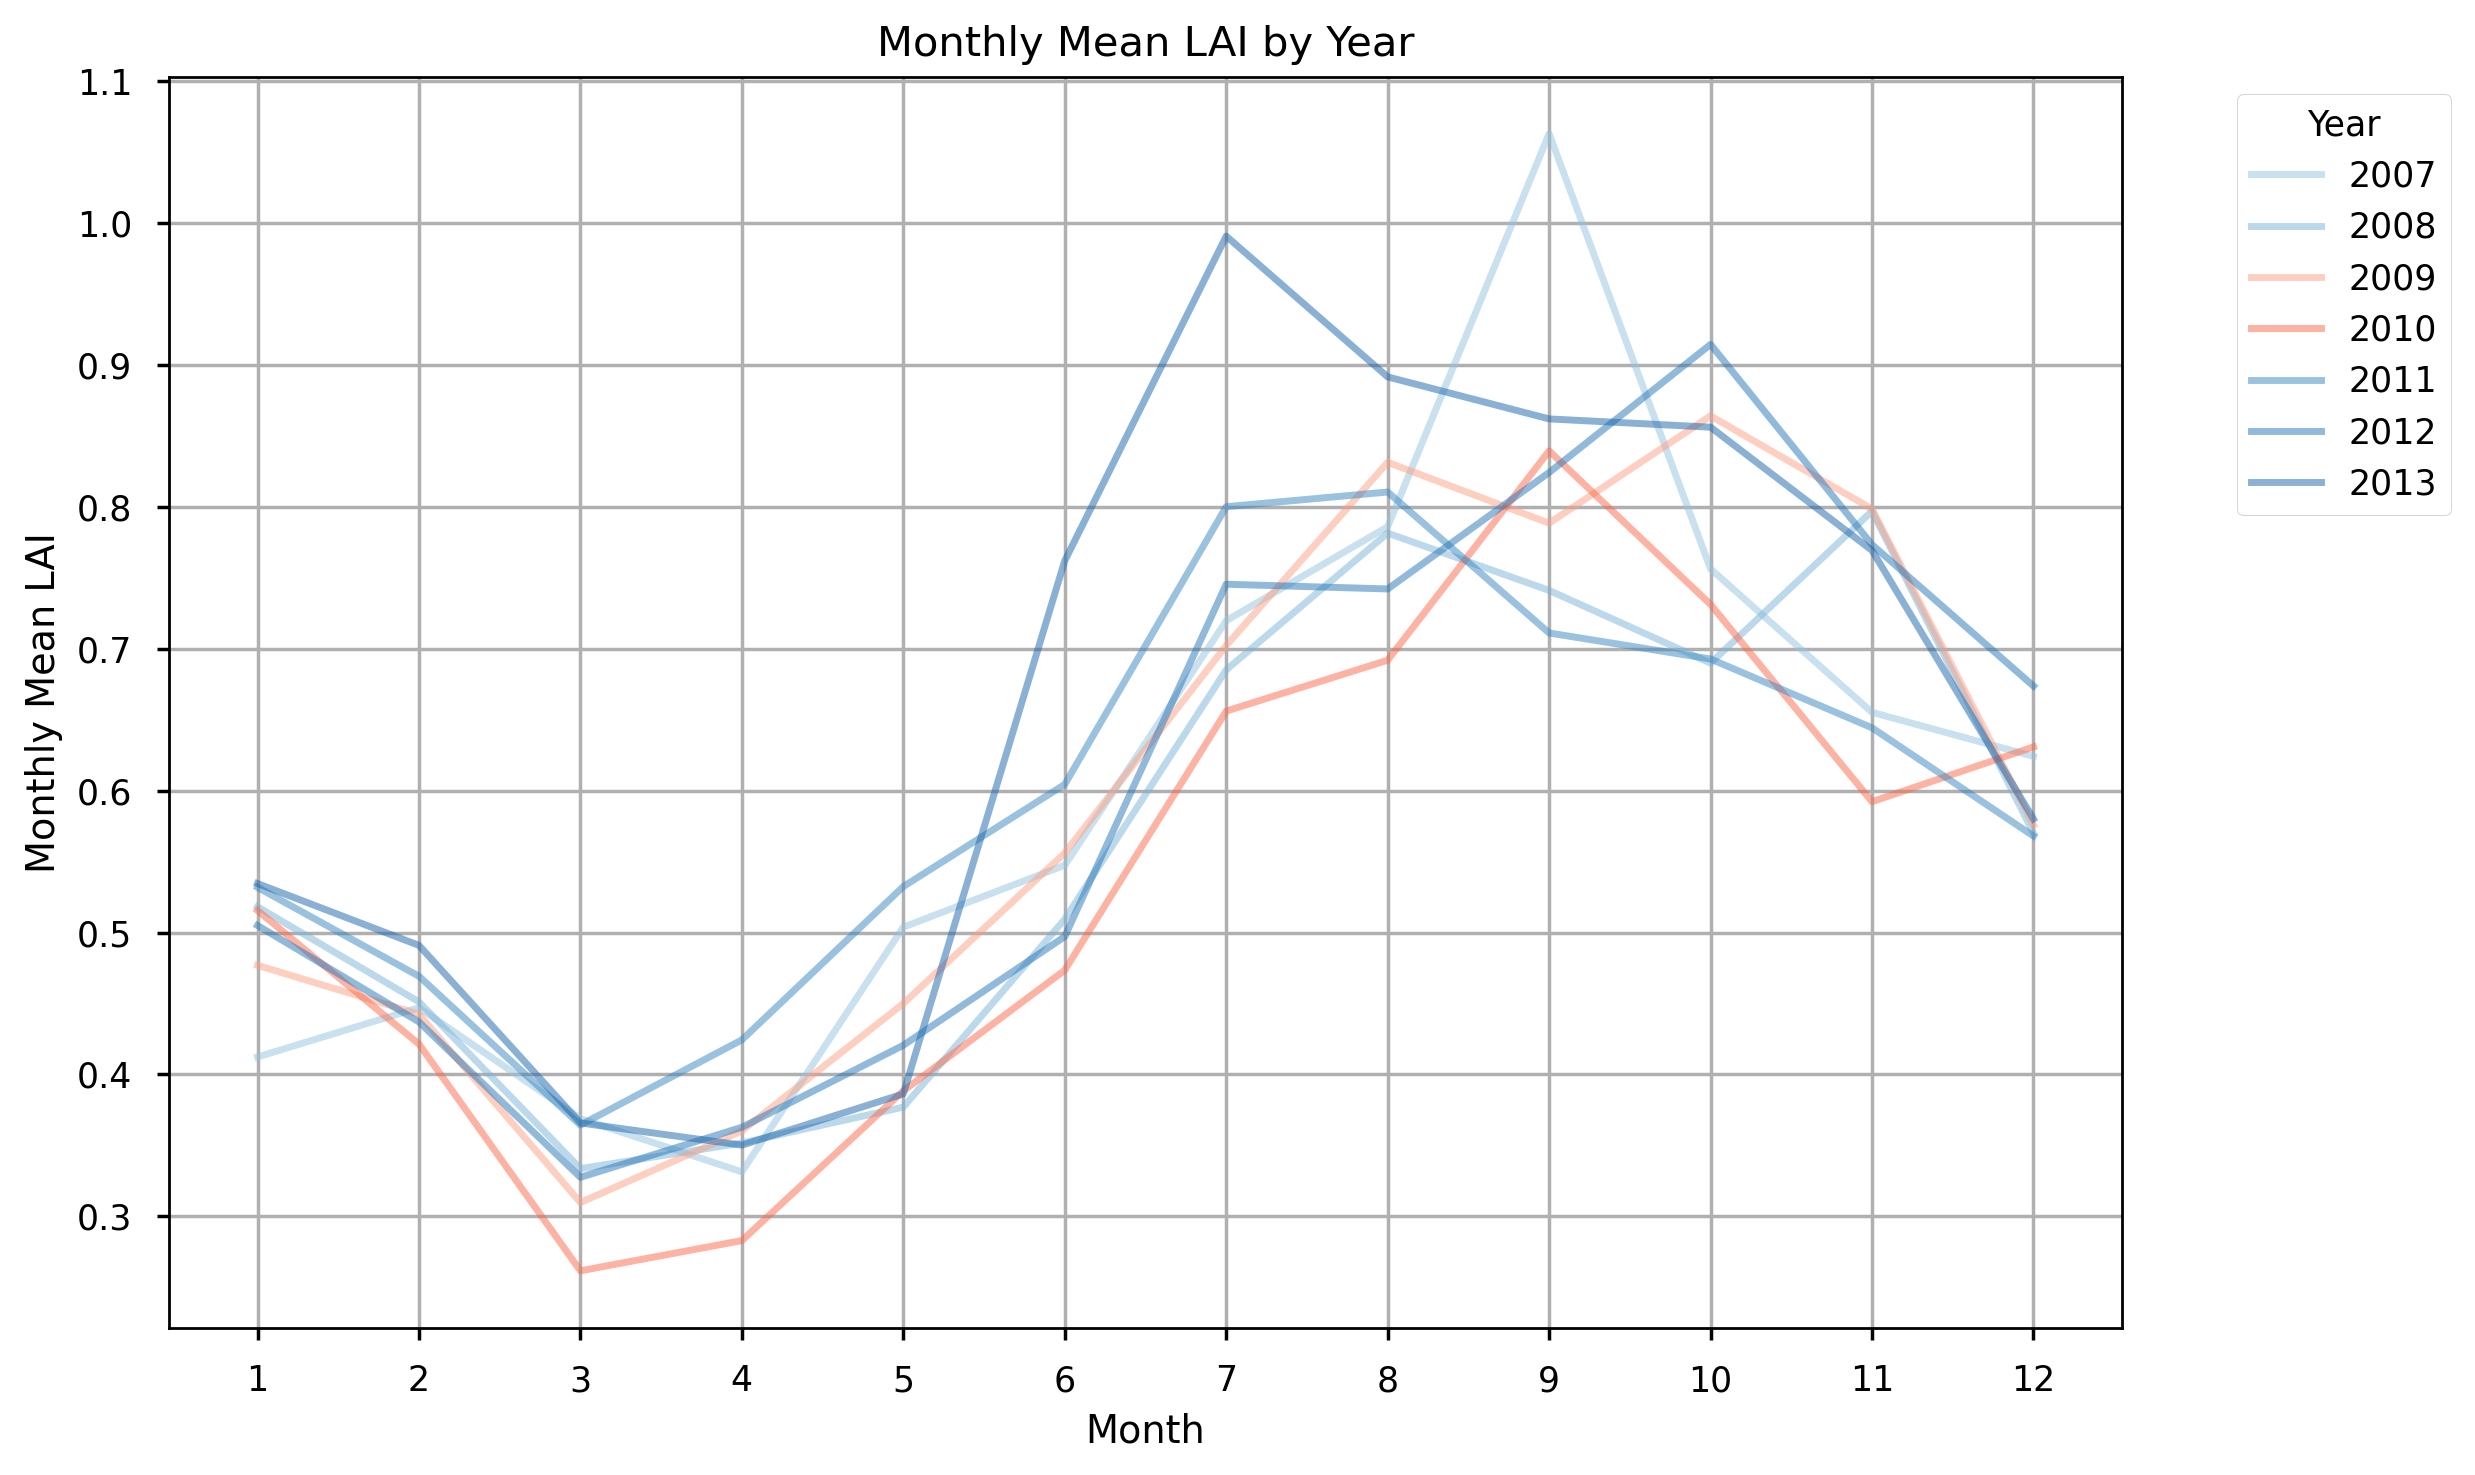

In [63]:
# Rename column 0 to 'LAI'
monthly_df = monthly_df.rename(columns={'0': 'LAI'})

# Setup
plt.figure(figsize=(10, 6), dpi=250)

years = sorted(monthly_df['year'].unique())

# Normalize to a fixed range and map to a subset of the colormaps
norm = mcolors.Normalize(vmin=min(years), vmax=max(years))

# Use a limited range of the colormaps for better visual balance
blue_cmap = cm.ScalarMappable(norm=norm, cmap=cm.Blues)
red_cmap = cm.ScalarMappable(norm=norm, cmap=cm.Reds)

for year in years:
    subset = monthly_df[monthly_df['year'] == year]
    
    # Slice the colormap manually (0.4 to 0.8 range)
    color_val = norm(year)
    if year in [2009, 2010]:
        color = cm.Reds(norm(year))  # Red: stay in 0.4–0.8 range
    else:
        color = cm.Blues(0.4 + 0.4 * color_val)  # Blue: stay in 0.4–0.8 range

    plt.plot(subset['month'], subset['LAI'], color=color, linewidth=2, label=str(year),alpha=0.5)

# Final touches
plt.xlabel('Month')
plt.ylabel('Monthly Mean LAI')
plt.title('Monthly Mean LAI by Year')
plt.xticks(range(1, 13))
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig("/data/wp5/trigoso_camila/LeafIndex/fig/monthly_mean_LAI.png", dpi=250, bbox_inches="tight")
plt.show()

```{figure} ef12d856-4e28-4480-be35-17ff2efc8975.png
---
name: fig-monthly_mean
figwidth: 100%
---
Monthly mean Leaf Area Index (LAI) for each year from 2007 to 2013, plotted by calendar month.
```

The spatial and monthly mean LAI (v3 form the CS3) in Yunnan was calculated. The values for the year 2009 appear to be around what is normal for that month in other non-drought years. However It can be observed that many months of 2010 are well below the values for the same month in other years. This can be because the drought had a stronger effect after a long time and started showing more in 2010. Also because the spatial mean averages out a big diverse area and more localized impacts on 2009 are not represented.

The spatial and monthly mean LAI (Version 3 from the CS3 dataset) in Yunnan was calculated. LAI values for 2009 appear to be within the typical range for that time of year when compared to other non-drought years. However, many months in 2010 show visibly lower values than the corresponding months in other years. This may be due to the delayed impact of the drought, with vegetation stress becoming more pronounced over time. Additionally, because the spatial mean averages conditions across a large and ecologically diverse area, localized drought effects in 2009 may be obscured in the overall average.

#### Standardized LAI anomaly

To identify areas in Yunnan where the Leaf Area Index (LAI) in 2010 was lower than in other non-drought years during the same dekad, the following standardized anomaly equation was applied:

$\text{LAI anomaly} = \frac{\text{LAI}_t - \overline{\text{LAI}}}{\delta_{\text{LAI}}}$

where:

$\text{LAI}_t$ = LAI 2010 for a specific dekad for that pixel

$\overline{\text{LAI}}$ = Mean LAI 2007-2008 and 2012-2013 for that same dekad for that pixel

$\delta_{\text{SMI}}$ = Standard deviation LAI 2007-2008 and 2012-2013 for that same dekad for that pixel

This method is similar to the standardized anomaly index calculated by Zhang et al. (2024). The reference periods 2007–2008 and 2012–2013 were chosen because they experienced minimal drought events and are adjacent to the drought years under investigation (2009–2010). This proximity helps control for long-term changes, such as those driven by human activity, that might otherwise skew the analysis [[3]](https://doi.org/10.1038/s41598-024-58068-w). For example, northwestern Yunnan was a key region in the Grain-for-Green Programme, which may have significantly influenced vegetation dynamics [[4]](https://www.sciencedirect.com/science/article/pii/S004896971631943X).

In [28]:
da=ds_relaxed["LAI"]
# Step 1: Select time range
da_normal = da.sel(
    time=((da.time.dt.year >= 2007) & (da.time.dt.year <= 2008)) |
         ((da.time.dt.year >= 2012) & (da.time.dt.year <= 2013))
).sortby("time")

# Step 2: Create 'dekad' coordinate
dekad_idx = np.tile([1, 2, 3], int(len(da_normal.time) / 3))

da_normal = da_normal.assign_coords(
    month=("time", da_normal.time.dt.month.data),  # <--- fixed here
    dekad=("time", dekad_idx)
)

# Step 3: Create composite month-dekad key
month_vals = da_normal.time.dt.month.data
month_dekad_labels = [f"{m:02d}-{d}" for m, d in zip(month_vals, dekad_idx)]

da_normal = da_normal.assign_coords(
    month_dekad=("time", month_dekad_labels)
)

# Step 4–5: Group and calculate
grouped = da_normal.groupby("month_dekad")
mean_normal = grouped.mean(dim="time")
std_normal = grouped.std(dim="time")

In [30]:
# Select data for 2009
da_2009 = da.sel(time=(da.time.dt.year == 2009)).sortby("time")

# Create dekad and month labels
dekad_idx = np.tile([1, 2, 3], int(len(da_2009.time) / 3))
month_vals = da_2009.time.dt.month.data
month_dekad_labels = [f"{m:02d}-{d}" for m, d in zip(month_vals, dekad_idx)]

# Assign new coordinates
da_2009 = da_2009.assign_coords(
    month=("time", month_vals),
    dekad=("time", dekad_idx),
    month_dekad=("time", month_dekad_labels)
)

# Group by month_dekad and calculate mean
lai_2009 = da_2009.groupby("month_dekad").mean(dim="time")

In [32]:
# Select data for 2010
da_2010 = da.sel(time=(da.time.dt.year == 2010)).sortby("time")

# Create dekad and month labels
dekad_idx = np.tile([1, 2, 3], int(len(da_2010.time) / 3))
month_vals = da_2010.time.dt.month.data
month_dekad_labels = [f"{m:02d}-{d}" for m, d in zip(month_vals, dekad_idx)]

# Assign new coordinates
da_2010 = da_2010.assign_coords(
    month=("time", month_vals),
    dekad=("time", dekad_idx),
    month_dekad=("time", month_dekad_labels)
)

# Group by month_dekad and calculate mean
lai_2010 = da_2010.groupby("month_dekad").mean(dim="time")

In [33]:
# Replace zeros in std with NaNs to avoid division by zero
std_normal_safe = std_normal.where(std_normal != 0)

# Calculate SMA safely 2009
lai_anom_2009 = (lai_2009 - mean_normal) / std_normal_safe
lai_anom_2009 = lai_anom_2009.where(np.isfinite(lai_anom_2009))  # Replace inf/-inf with NaN

# Calculate SMA safely 2010
lai_anom_2010 = (lai_2010 - mean_normal) / std_normal_safe
lai_anom_2010 = lai_anom_2010.where(np.isfinite(lai_anom_2010))  # Replace inf/-inf with NaN

In [41]:
# Define custom colormap and boundaries
colors = [
    "#e12d62",  # <-2
    "#ff8c95",  # -2 to -1.5
    "#ffdfc8",  # -1.5 to -1
    "#ffffff",  # -1 to 1
    "#a9eb5f",  # 1 to 1.5
    "#3ba521",  # 1.5 to 2
    "#006e13"   # >= 2
]
bounds = [-100, -2, -1.5, -1, 1, 1.5, 2, 100]  # Define boundaries

# Create colormap and norm
cmap = mcolors.ListedColormap(colors)
cmap.set_bad(color='lightgray')  # Gray for no data
norm = mcolors.BoundaryNorm(bounds, ncolors=len(colors), clip=True)

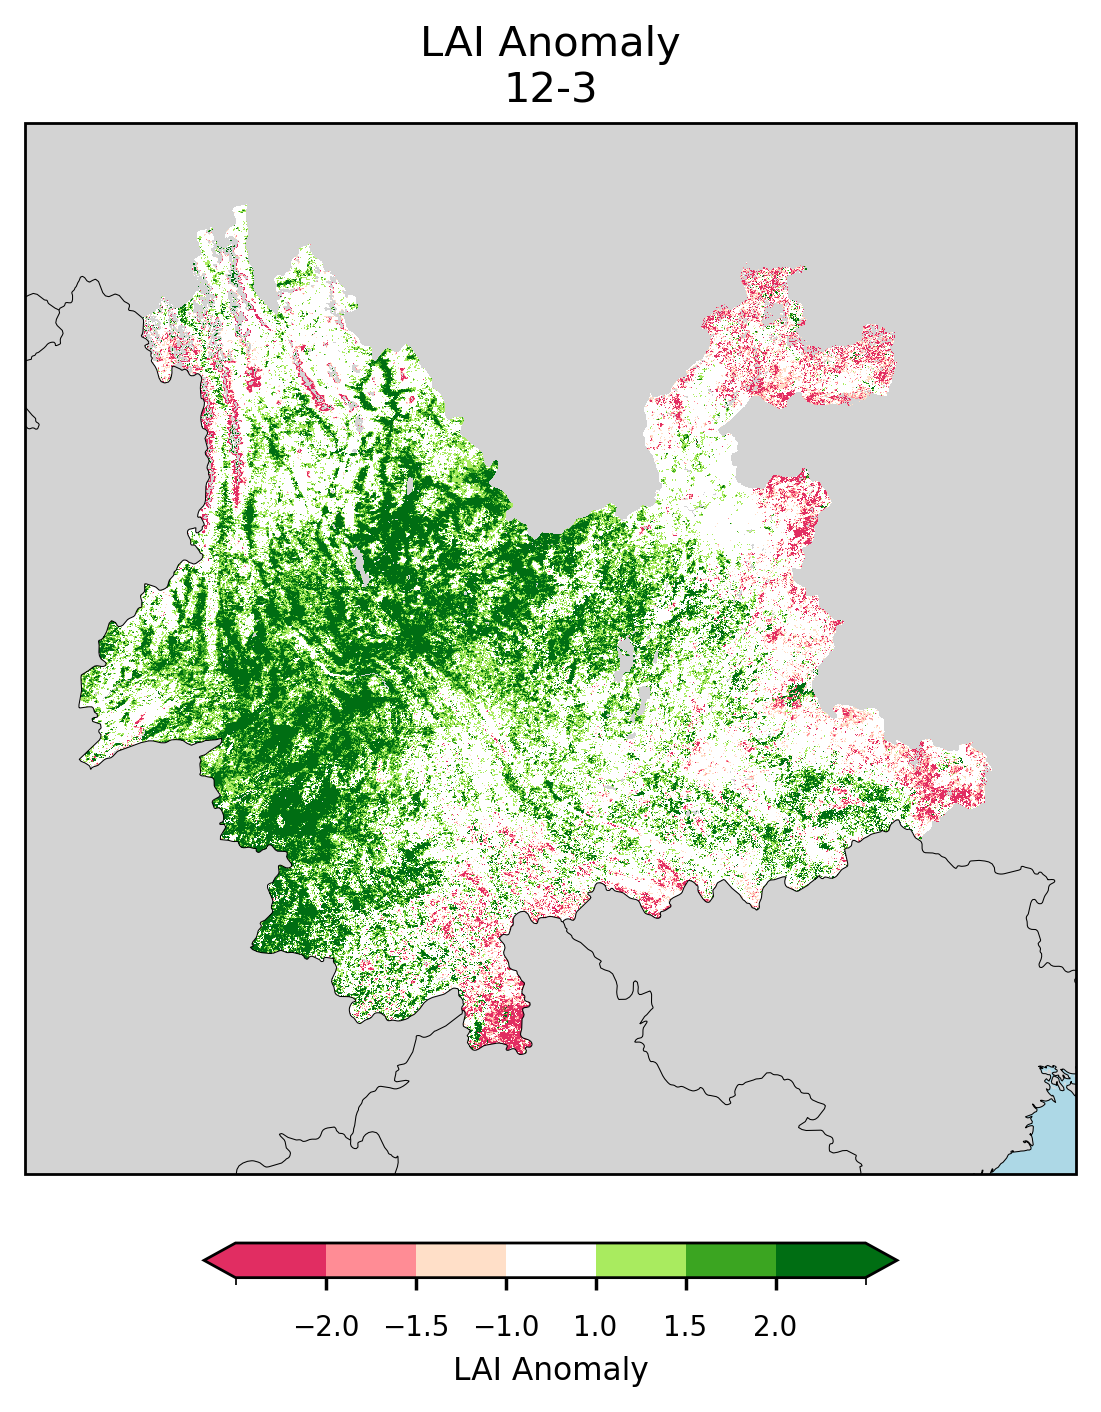

In [44]:
# Extract time labels for titles
time_labels = lai_anom_2010['month_dekad'].values  # e.g., ['01-1', '01-2', ..., '12-3']

# Set up the plot
fig, ax = plt.subplots(
    figsize=(8, 6),
    subplot_kw={'projection': ccrs.PlateCarree()},
    dpi=250
)

ax.set_extent([97, 107, 20, 30], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Initial plot: first time slice
initial_data = lai_anom_2010.isel(month_dekad=0)

im = ax.pcolormesh(
    lai_anom_2010.longitude,
    lai_anom_2010.latitude,
    initial_data,
    cmap=cmap,
    norm=norm,
    transform=ccrs.PlateCarree()
)

title = ax.set_title(f"LAI Anomaly\n{time_labels[0]}", fontsize=12)

# Colorbar with bounds and ticks
ticks = bounds[1:-1]
cbar = fig.colorbar(
    im, ax=ax, orientation='horizontal',
    fraction=0.03, pad=0.06, shrink=0.9,
    ticks=ticks,
    extend='both'
)
cbar.ax.tick_params(labelsize=8)
cbar.set_label('LAI Anomaly', fontsize=9)

# Update function for animation frames
def update(frame_idx):
    data = lai_anom_2010.isel(month_dekad=frame_idx)
    # pcolormesh expects flattened data array
    im.set_array(data.values.ravel())
    title.set_text(f"LAI Anomaly\n{time_labels[frame_idx]}")
    return im,

# Create animation object
ani = animation.FuncAnimation(
    fig, update, frames=len(time_labels), blit=False, interval=500
)

# Save animation as GIF
ani.save("/data/wp5/trigoso_camila/LeafIndex/fig/yunnan_animation_lai_anom2010.gif", writer='pillow', dpi=250)

plt.show()

```{figure} 21c65897-6b5a-4b9e-88db-ebd175c7bf93.gif
---
name: fig-anomaly
figwidth: 100%
---
Animated map of Leaf Area Index (LAI) anomalies over Yunnan Province for each dekad (10-day period) of 2010. The first number in the title is the month and the second the number of dekad.
```

In January 2010, more zones in Yunnan exhibited positive LAI anomalies than negative ones. However, from mid-February to early March, negative anomalies increased, particularly in southern and central Yunnan. By mid- to late March, negative LAI anomalies had expanded significantly, covering a larger portion of the province. In the third dekad of March, almost all of Yunnan experienced lower LAI values compared to the same dekads in adjacent non-drought years.

During April and May, the spatial pattern of anomalies became more mixed, with both positive and negative values present. Nevertheless, the southern and especially southeastern regions continued to display persistent negative anomalies.

These observations are consistent with the findings of Zhang et al. (2024), who analyzed LAI anomalies along the Tropic of Cancer section of Yunnan, corresponding to the southern part of the province between 23–24°N latitude. Their study concluded that the vegetation in Yunnan was most severely impacted between March and May 2010, a period when the cumulative effects of drought and seasonal vegetation cycles contributed to the decline [[3]](https://doi.org/10.1038/s41598-024-58068-w).

From late May to early June, coinciding with the onset of the wet season, there was an increase in positive anomalies. But this was short-lived — from mid-June to late July, negative anomalies returned, though they appeared more scattered (dotted) rather than forming large continuous blocks as seen during the peak of the dry season. 

In August and September, conditions improved, with a greater presence of positive anomalies, especially by mid- to late September, when positive values became widespread.

By late October, the trend reversed again, with negative anomalies emerging, particularly in the northwest. These became significantly more severe in November, eventually covering most of northwestern Yunnan by late November.

Finally, in December, vegetation conditions improved, with signs of greening in the southwest and near-normal LAI levels across much of the rest of the province.

## ℹ️ If you want to know more

* Zhu, H. & Tan, Y. (2022). Flora and Vegetation of Yunnan, Southwestern China: Diversity, Origin and Evolution. Diversity, 14(5), 340. [](https://www.mdpi.com/1424-2818/14/5/340)
* Qian, L.-S., Chen, J.-H., Deng, T., & Sun, H. (2020). Plant diversity in Yunnan: Current status and future directions. Plant Diversity, 42(4), 281–291. [](https://doi.org/10.1016/j.pld.2020.07.006)
* Lan, T., & Yan, X. (2024). Analysis of drought characteristics and causes in Yunnan Province in the last 60 years (1961–2020). Journal of Hydrometeorology, 25, 177–190. [](https://doi.org/10.1175/JHM-D-23-0092.1) 

### Key resources

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)

Documentation:
* [Product User Guide and Specification (PUGS) - Multi-sensor CDR LAI and fAPAR v3.0](https://dast.copernicus-climate.eu/documents/satellite-lai-fapar/D3.3.9-v3.0_PUGS_CDR_LAI_FAPAR_MULTI_SENSOR_v3.0_PRODUCTS_v1.0.1.pdf)
* [Algorithm Theoretical Basis Document (ATBD) - Multi-sensor CDR LAI and fAPAR v3.0](https://dast.copernicus-climate.eu/documents/satellite-lai-fapar/D1.4.4-v3.0_ATBD_CDR_LAI_FAPAR_MULTI_SENSOR_v3.0_PRODUCTS_v1.0.1.pdf)
* [Product Quality Assurance Document (PQAD) - Multi-sensor LAI and fAPAR v3.0](https://dast.copernicus-climate.eu/documents/satellite-lai-fapar/D2.2.9-v3.0_PQAD_CDR_LAI_FAPAR_MULTI_SENSOR_v3.0_PRODUCTS_v1.1.pdf)
* [Product Quality Assessment Report (PQAR) - Multi-sensor LAI and fAPAR v3.0](https://dast.copernicus-climate.eu/documents/satellite-lai-fapar/D2.3.9-v3.0_PQAR_CDR_LAI_FAPAR_MULTI_SENSOR_v3.0_PRODUCTS_v1.1.pdf)

### References

[[1]](https://www.sciencedirect.com/science/article/pii/S1872203213000577?casa_token=42igXD4HJb0AAAAA:dUjDmwTtatAJjay4r4YeTUM72Dobqck7rnenPh_nHku9aJD8nt68FQMmJFKZBka0YgV56oLZ_ky4) Yu, W., Shao, M., Ren, M., Zhou, H., Jiang, Z., & Li, D. (2013). Analysis on spatial and temporal characteristics of drought in Yunnan Province. Acta Ecologica Sinica, 33(6), 317–324.

[[2]](https://doi.org/10.1007/s11629-016-3971-x) Kim, K., Wang, M.-c., Ranjitkar, S., Liu, S.-h., Xu, J.-c., & Zomer, R. J. (2017). Using leaf area index (LAI) to assess vegetation response to drought in Yunnan province of China. J. Mt. Sci. 14, 1863–1872.

[[3]](https://doi.org/10.1038/s41598-024-58068-w) Zhang, Y., Gu, T., He, S., Cheng, F., Wang, J., Ye, H., Zhang, Y., Su, H., & Li, Q. (2024). Extreme drought along the tropic of cancer (Yunnan section) and its impact on vegetation. Sci Rep 14, 7508.

[[4]](https://www.sciencedirect.com/science/article/pii/S004896971631943X) Wang, J., Peng, J., Zhao, M., Liu, Y., & Chen, Y. (2017). Significant trade-off for the impact of Grain-for-Green Programme on ecosystem services in North-western Yunnan, China. Science of The Total Environment, 574, 57–64.